In [1]:
import re
import optuna
import json
import joblib

import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

from datetime import datetime
from nltk import corpus
from pathlib import Path
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix

In [2]:
plot_config = {
    'figure.facecolor': 'white',
    'font.size': 12,
    'axes.titlepad': 10,
    'axes.titlesize': 18,
    'axes.labelsize': 15,
}

plt.rcParams.update(plot_config)

# Data preparation

In [3]:
def simple_preprocessing(txt, stopwords=None):
    
    # Lowercasing - works on accented characters too
    txt = txt.lower()
    
    # Remove bracket & content
    txt = re.sub('\(.*?\)', ' ', txt)
    
    # Convert accented characters to their closest ASCII character
    # e.g. Gönül -> Gonul
    txt = unidecode(txt)
    
    # Remove anything that isn't a-z
    txt = re.sub('[^a-z ]', ' ', txt)
    
    # Standardize spacing
    txt = re.sub('\s+',' ', txt).strip()
    
    if stopwords is not None:
        # Remove stopwords
        sw_pattern = '\\b(' + '|'.join(stopwords) + ')\\b'
        txt = re.sub(sw_pattern, ' ', txt)

        # Standardize spacing again
        txt = re.sub('\s+',' ', txt).strip()
    
    return txt

In [4]:
# Read data
data_folder = Path('../data/')
feat_path = data_folder / 'features.csv'
lab_path = data_folder / 'labels.csv'

df_feat = pd.read_csv(feat_path)
df_lab = pd.read_csv(lab_path)
df = df_feat.merge(df_lab, on='trackID')

del df_feat, df_lab

# Specify vector columns
sel = df.columns.str.startswith('vect')
vec_cols = df.columns[sel]

In [5]:
# Dropna rows and reset index
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Generate new feature
df['time_sig_mt4'] = (df['time_signature'] > 4).astype(float)

# COmbine key & mode, and one hot encode them
df[['key','mode']] = (
    df[['key','mode']]
    .applymap(lambda x : f'{int(x):02d}')
)

df['key_mode'] = (
    df[['key','mode']]
    .apply(lambda x : '|'.join(x), axis=1)
)

key_mode_cols = sorted(df['key_mode'].unique())

for col in key_mode_cols:
    df[col] = (df['key_mode'] == col).astype(float)

In [6]:
# Get & process stopwords
stopwords = list(map(simple_preprocessing, corpus.stopwords.words('english')))

# Processed tags
df['processed_tags'] = df['tags'].apply(lambda x : simple_preprocessing(x, stopwords))

In [7]:
# Select uncorrelated columns

corr_mat = df[vec_cols].corr().abs()

thres = 0.9

# Convert to array, mask diagonal, since it is always 1
corr_mat_arr = corr_mat.values
np.fill_diagonal(corr_mat_arr, 0)

cols_remaining = list(np.arange(len(corr_mat_arr)))

for i in range(len(corr_mat_arr)):
    
    if i not in cols_remaining:
        continue
        
    idx_to_removed = np.where(corr_mat_arr[i] > thres)[0]
    
    for idx in idx_to_removed:
        try:
            _ = cols_remaining.remove(idx)
        except ValueError:
            pass
        
selected_vec_cols = vec_cols[cols_remaining]

In [8]:
# Feature col selection
float_cols = ['loudness','tempo'] + selected_vec_cols.to_list()
cat_cols = ['time_sig_mt4'] + key_mode_cols

In [9]:
# Generate label to id mapping
label2id = dict((genre, i) for i, genre in enumerate(df['genre'].unique()))
labels = df['genre'].map(label2id).values

# Set class weights to take care of minority class
class_weight = (
    1 / (df['genre'].value_counts() / df['genre'].value_counts().max())
).to_dict()

# Convert to idx, since we will be passing in label id instead of label string
idx_class_weight = dict((label2id[c], w) for c, w in class_weight.items())

In [10]:
# Generate data for different fold & keep in memory
# We can do so since the dataset is very small

fold_data = dict()
n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, random_state=2021, shuffle=True)

fold_data = dict()
vect_dict = dict()

for i, (train_idx, test_idx) in enumerate(skf.split(df.index, df['genre'])):
    
    fold_name = f'Fold_{i}'
    
    vectorizer = TfidfVectorizer(
        ngram_range=(1,2),
        max_features=5_000
    )
    
    x_tfidf_train = vectorizer.fit_transform(df.iloc[train_idx]['processed_tags']).toarray()
    x_tfidf_test = vectorizer.transform(df.iloc[test_idx]['processed_tags']).toarray()

    x_float_train = df.iloc[train_idx][float_cols].values
    x_float_test = df.iloc[test_idx][float_cols].values

    x_cat_train = df.iloc[train_idx][cat_cols].values
    x_cat_test = df.iloc[test_idx][cat_cols].values

    x_train = np.column_stack([x_tfidf_train, x_float_train, x_cat_train])
    x_test = np.column_stack([x_tfidf_test, x_float_test, x_cat_test])

    y_train = labels[train_idx]
    y_test = labels[test_idx]

    y_train = labels[train_idx]
    y_test = labels[test_idx]
    
    # Save fold data & vectorizer
    fold_data[fold_name] = (x_train, x_test, y_train, y_test)
    vect_dict[fold_name] = vectorizer

for i, (x_train, x_test, y_train, y_test) in fold_data.items():
    print(i, x_train.shape, x_test.shape, y_train.shape, y_test.shape)

Fold_0 (5793, 5117) (1931, 5117) (5793,) (1931,)
Fold_1 (5793, 5117) (1931, 5117) (5793,) (1931,)
Fold_2 (5793, 5117) (1931, 5117) (5793,) (1931,)
Fold_3 (5793, 5117) (1931, 5117) (5793,) (1931,)


# Optuna Hyperparam Tuning

In [11]:
def objective(trial):
    
    param = {
        'objective': 'multiclass',
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 31),
        'max_depth': trial.suggest_int('max_depth', 2, 7),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 30),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 500, 6000),
    }
    
    test_acc_list = []
    
    # We are passing in several globals, not a good practice (but it is ez to prototype!)
    for i, (x_train, x_test, y_train, y_test) in fold_data.items():
        
        clf = lgb.LGBMClassifier(
            class_weight=idx_class_weight,
            n_estimators=3000,
            **param
        )

        clf.fit(
            x_train, y_train,
            eval_metric='logloss',
            eval_set=[(x_test, y_test)],
            early_stopping_rounds=100,
            verbose=0
        )
        y_test_pred = clf.predict(x_test)

        test_acc = accuracy_score(y_test, y_test_pred)
        test_acc_list.append(test_acc)
    
    return np.mean(test_acc_list)

In [12]:
# Takes about 4 hours to run a study with 200 trials on i7-10750H CPU

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200, show_progress_bar=True)

date_str = datetime.now().strftime('%Y%m%d')
study_results_path = data_folder / f"lgb_tuning_results_{date_str}.csv"
study.trials_dataframe().to_csv(study_results_path, index=False)

/home/chewzy/Personal/dbs_data_science/.venv/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

# Recreate Best Model & Save Model Files

<AxesSubplot:title={'center':'Optuna Tuning Results'}, xlabel='# of Trials', ylabel='Accuracy'>

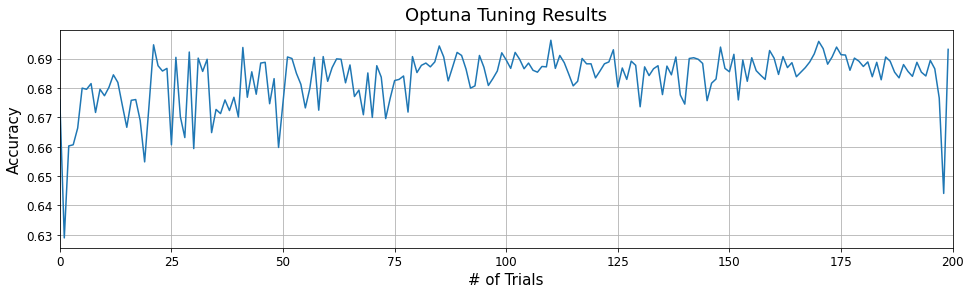

In [13]:
df_study = pd.read_csv(study_results_path)

df_study.plot(
    x='number',
    y='value',
    legend=False,
    ylabel='Accuracy',
    xlabel='# of Trials',
    title='Optuna Tuning Results',
    figsize=(16,4),
    grid=True,
    xlim=(0, len(df_study))
)

In [14]:
sel = df_study.columns.str.startswith('params')
param_cols = df_study.columns[sel]
param_cols_rename = dict((col, col.replace('params_','')) for col in param_cols)

df_study.rename(columns=param_cols_rename, inplace=True)

In [15]:
sel = df_study['value'] == max(df_study['value'])

best_params = (
    df_study
    .loc[sel, param_cols_rename.values()]
    .to_dict(orient='records')
    [0]
)

CPU times: user 9min 7s, sys: 853 ms, total: 9min 7s
Wall time: 48.2 s


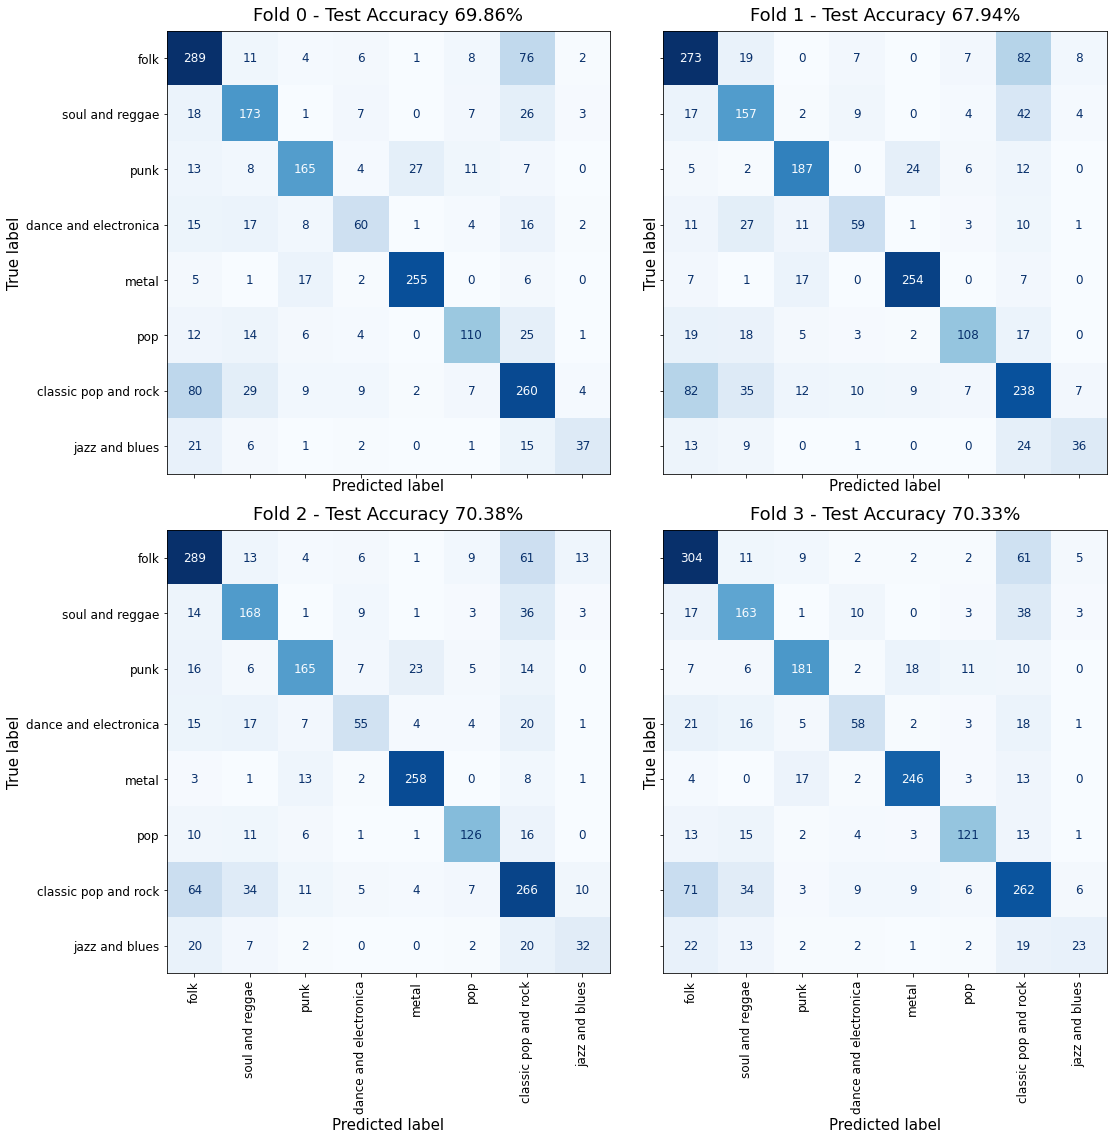

In [16]:
%%time

# Recreate best trial and check confusion matrix
# Save all the files required for model deployment

model_folder = Path('../model/deployment')

if not model_folder.exists():
    model_folder.mkdir(parents=True)
    
# Save label mapping
with open(model_folder / 'label2id.json', 'w') as f:    
    json.dump(label2id, f)

# Define plot    
fig, ax = plt.subplots(2,2,figsize=(16,16), sharex=True, sharey=True)
ax = ax.ravel()

for i, (fold_name, (x_train, x_test, y_train, y_test)) in enumerate(fold_data.items()):
            
    # Make folder for fold
    fold_folder = model_folder / fold_name.lower()
    
    if not fold_folder.exists():
        fold_folder.mkdir(parents=True)
        
    # Save vectorizer (previously fitted)
    joblib.dump(vect_dict[fold_name], fold_folder / 'tfidf.vec')

    clf = lgb.LGBMClassifier(
        class_weight=idx_class_weight,
        n_estimators=3000,
        **best_params
    )

    clf.fit(
        x_train, y_train,
        eval_metric='logloss',
        eval_set=[(x_test, y_test)],
        early_stopping_rounds=100,
        verbose=0
    )
    
    # Save lgb model
    clf.booster_.save_model((fold_folder / 'lgb.txt').as_posix())
    
    y_test_pred = clf.predict(x_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    plot_confusion_matrix(
        clf,
        x_test,
        y_test,
        labels=list(label2id.values()),
        display_labels=list(label2id.keys()),
        xticks_rotation='vertical',
        colorbar=False,
        cmap='Blues', ax=ax[i]
    )

    ax[i].set_title(f"{fold_name.replace('_', ' ')} - Test Accuracy {test_acc:.2%}")
    
plt.tight_layout()